# Layout LM v2

LayoutLMv2 architecture is proposed with new pre-training tasks to model the interaction among text, layout, and image in a single multi-modal framework. 

Specifically, with a two-stream multi-modal Transformer encoder, LayoutLMv2 uses not only the existing masked visual-language modeling task but also the new text-image alignment and text-image matching tasks, which make it better capture the cross-modality interaction in the pre-training stage. Meanwhile, it also integrates a spatial-aware self-attention mechanism into the Transformer architecture so that the model can fully understand the relative positional relationship among different text blocks.

The core difference between vanilla LayoutLM and LayoutLMv2 is that in the vanilla LayoutLM visual embeddings are combined in the fine-tuning stage, whereas we integrate the visual information in the pre-training stage in LayoutLMv2 by taking advantage of the Transformer architecture to learn the cross-modality interaction between visual and textual information.

## Architecture Details

A multi-modal Transformer architecture which takes text, visual, and layout information as input to establish deep cross-modal interactions acts as the backbone of LayoutLMv2

LayoutLMv2 also introduces a spatial-aware self-attention mechanism to the model architecture for better modeling the document layout.

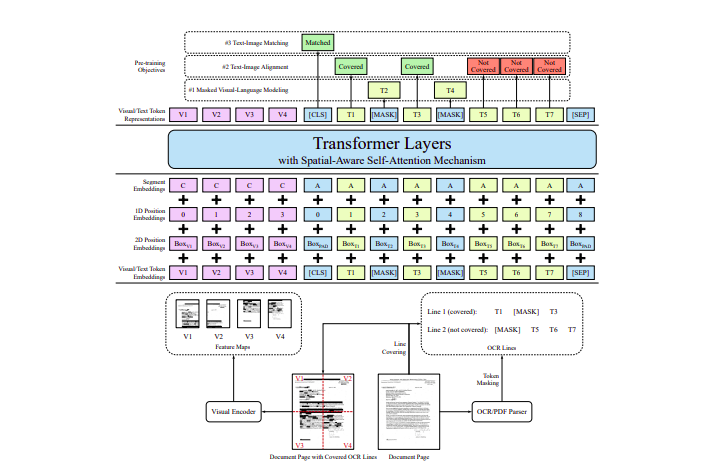

**Text Embeddings**

Following the common practice, LayoutLMv2 use WordPiece to tokenize the OCR text sequence and assign each token to a certain segment si ∈ {[A], [B]}. Then, [CLS] is added at the beginning of the sequence and [SEP] at the end of each text segment. Extra [PAD] tokens are appended to the end so that the final sequence’s length is exactly the maximum sequence length L. The final text embedding is the sum of three embeddings.

1. Token embedding represents the token itself
2. 1D positional embedding represents the token index
3. Segment embedding is used to distinguish different text segments

Formally, we have the i-th (0 ≤ i < L) text embedding

<center><b>ti = TokEmb(wi)+PosEmb1D(i)+SegEmb(si)</b></center>

**Visual Embedding**

LayoutLMv2 leverages the output feature map of a CNN-based visual encoder, which converts the page image to a fixed-length sequence. Specifically it uses ResNeXt-FPN architecture as the backbone of the visual encoder, whose parameters can be updated through backpropagation.

Given a document page image I, it is resized to 224 × 224 then fed into the visual backbone. After that, the output feature map is average-pooled to a fixed size with the width being W and height being H. Next, it is flattened into a visual embedding sequence of length W ×H. The sequence is named VisTokEmb(I). A linear projection layer is then applied to each visual token embedding to unify the dimensionality with the text embeddings.

Since the CNN-based visual backbone cannot capture the positional information, we also add a 1D positional embedding to these visual token embeddings. The 1D positional embedding is shared with the text embedding layer. For the segment embedding, we attach all visual tokens to the visual segment [C].

The i-th (0 ≤ i < W H) visual embedding can be represented as

<center><b>vi = Proj(VisTokEmb(I)i) + PosEmb1D(i) + SegEmb([C])</b></center>

**Layout Embedding**

The layout embedding layer is for embedding the spatial layout information represented by axis-aligned token bounding boxes from the OCR results, in which box width and height together with corner coordinates are identified. Following the vanilla LayoutLM, we normalize and discretize all coordinates to integers in the range [0, 1000], and use two embedding layers to embed x-axis features and y-axis features separately. The layout embedding layer is for embedding the spatial layout information represented by axis-aligned token bounding boxes from the OCR results, in which box width and height together with corner coordinates are identified. Following the vanilla LayoutLM, we normalize and discretize all coordinates to integers in the range [0, 1000], and use two embedding layers to embed x-axis features and y-axis features separately. 

Given the normalized bounding box of the i-th (0 ≤ i < W H + L) text/visual token boxi = (xmin, xmax, ymin, ymax, width, height), the layout embedding layer concatenates six bounding box features to construct a token-level 2D positional embedding, aka the layout embedding 

<center><b>li = Concat(PosEmb2Dx(xmin, xmax, width), PosEmb2Dy(ymin, ymax, height))</b></center>


Note that CNNs perform local transformation, thus the visual token embeddings can be mapped back to image regions one by one with neither overlap nor omission. When calculating bounding boxes, the visual tokens can be treated as evenly divided grids. An empty bounding box boxPAD = (0, 0, 0, 0, 0, 0) is attached to special tokens [CLS], [SEP] and [PAD].


**Multi-modal Encoder with Spatial-Aware SelfAttention Mechanism** 

The encoder concatenates visual embeddings {v0, ..., vW H−1} and text embeddings {t0, ..., tL−1} to a unified sequence and fuses spatial information by adding the layout embeddings to get the i-th (0 ≤ i < W H + L) first layer input 

<center><b> x(0)i = Xi + li, where X = {v0, ..., vW H−1, t0, ..., tL−1}</b></center>


Following the architecture of Transformer, we build our multi-modal encoder with a stack of multi-head self-attention layers followed by a feedforward network. However, the original selfattention mechanism can only implicitly capture the relationship between the input tokens with the absolute position hints. In order to efficiently model local invariance in the document layout, it is necessary to insert relative position information explicitly. Therefore, we introduce the spatial-aware self-attention mechanism into the self-attention layers.

## Pre-Trained Layout LM v2

**Masked Visual-Language Modeling**: Similar to the vanilla LayoutLM, we use the Masked VisualLanguage Modeling (MVLM) to make the model learn better in the language side with the crossmodality clues. We randomly mask some text tokens and ask the model to recover the masked tokens. Meanwhile, the layout information remains unchanged, which means the model knows each masked token’s location on the page. The output representations of masked tokens from the encoder are fed into a classifier over the whole vocabulary, driven by a cross-entropy loss. To avoid visual clue leakage, we mask image regions corresponding to masked tokens on the raw page image input before feeding it into the visual encoder

**Text-Image Alignment**:ent To help the model learn the spatial location correspondence between image and coordinates of bounding boxes, we propose the Text-Image Alignment (TIA) as a fine-grained cross-modality alignment task. In the TIA task, some tokens lines are randomly selected, and their image regions are covered on the document image. We call this operation covering to avoid confusion with the masking operation in MVLM.

During pretraining, a classification layer is built above the encoder outputs. This layer predicts a label for each text token depending on whether it is covered, and computes the binary cross-entropy loss. Considering the input image’s resolution is limited, and some document elements like signs and bars in a figure may look like covered text regions, the task of finding a word-sized covered image region can be noisy. Thus, the covering operation is performed at the line-level

**Text-Image Matching**: Furthermore, a coarse grained cross-modality alignment task, Text-Image
Matching (TIM) is applied to help the model learn the correspondence between document image and
textual content. We feed the output representation at [CLS] into a classifier to predict whether the image and text are from the same document page.

Regular inputs are positive samples. To construct a negative sample, an image is either replaced by a page image from another document or dropped. To prevent the model from cheating by finding task features, we perform the same masking and covering operations to images in negative samples. The TIA target labels are all set to [Covered] in negative samples. We apply the binary cross-entropy loss in the optimization process.

For Pre-training IIT-CDIP dataset is used

## Fine Tuned Layout LM v2
The Pre-Trained Layout LM v2 is finetuned on six publicly available benchmark datasets as the downstream tasks to evaluate the performance

1. FUNSD dataset: for form understanding
2. CORD dataset: for receipt understanding
3. SROIE dataset: for receipt understanding
4. Kleister-NDA dataset: for long document understanding with a complex layout
5. RVL-CDIP dataset: for document image classification
6. DocVQA dataset: for visual question answering on document images

**Reference**

LayoutLMv2: Multi-modal Pre-training for Visually-rich Document Understanding, paper: [2012.14740](https://arxiv.org/pdf/2012.14740.pdf)

# Layout LM v2 in Action
Here are the implementations of Layout LM v2 on custom datasets
1. [**Document Classifcation**](https://www.kaggle.com/code/ritvik1909/layoutlmv2-document-classification)
2. [**Information Extraction**](https://www.kaggle.com/code/ritvik1909/layoutlmv2-information-extraction)